<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">GROUP 80 - Amazon Reviews For Sentiment Analysis</h1>
</center>

## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border: 10px solid #80ffff"> TABLE OF CONTENTS<br><div>  

* Import Libraries
* Read Data & Text Cleaning
* Word Cloud
* Tokeniztion & pad_sequences
* Model
* Evaluate

## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Import Libraries<br><div> 


In [1]:
import re
import gc
import bz2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import multiprocessing
from joblib import Parallel, delayed

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Read Data<br><div>

Data format
![image.png](img/train.png)

In [2]:
import bz2
# Load data bz2
def get_data_from_file_bz2(filepath):
    labels = []
    texts = []
    for line in bz2.BZ2File(filepath):
        line = line.decode("utf-8")
        #       012345678901
        # line: __label__2 Stuning even for the non-gamer...
        labels.append(int(line[9]) - 1)
        texts.append(line[11:].strip())
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

In [3]:
def get_data_from_file(filepath):
    labels = []
    texts = []
    with open(file=filepath, mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            #       012345678901
            # line: __label__2 Stuning even for the non-gamer...
            labels.append(int(line[9]))
            texts.append(line[11:].strip())
    
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

# Load train data file
train_filepath = 'train.3270.txt'
df_train = get_data_from_file(train_filepath)

# Load test data file
test_filepath = 'test.135.txt'
df_test = get_data_from_file(test_filepath)

del train_filepath, test_filepath

In [4]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3270 non-null   int64 
 1   text    3270 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.2+ KB
None


In [5]:
print(f"First text: {df_train['text'][0]},\nFirst Label: {df_train['label'][0]}")

First text: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^,
First Label: 2


In [6]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   135 non-null    int64 
 1   text    135 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


In [7]:
print(f"First text: {df_test['text'][0]},\nFirst Label: {df_test['label'][0]}")

First text: Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?",
First Label: 2


<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Text Cleaning<br><div>

In [8]:
# Function to preprocess text
def text_cleaning(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'(?:https?:\/\/(?:www\.|(?!www))|www\.)[\w\-\.\+/?=&#@:%~]+', 'URL', text)
    # Remove punctuation and special characters
    text = re.sub(r'[\W_]+', ' ', text)
    return text


# Train data text cleaning
df_train['clean_text'] = df_train['text'].apply(text_cleaning)

# Test data text cleaning
df_test['clean_text'] = df_test['text'].apply(text_cleaning)

In [9]:
print(f"First text: {df_train['text'][0]}")
print(f"Clean Text: {df_train['clean_text'][0]}")

First text: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Clean Text: stuning even for the non gamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen 


<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Stop Words Removal<br><div>

In [10]:
# Stop words
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('stopwords')

# Initialize stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)


# Train data remove stopwords
df_train['text_wo_stopwords'] = df_train['clean_text'].apply(remove_stopwords)

# Test data remove stopwords
df_test['text_wo_stopwords'] = df_test['clean_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
print(f"First text:                     {df_train['text'][0]}")
print(f"Clean Text:                     {df_train['clean_text'][0]}")
print(f"Clean Text Without Stopwords:   {df_train['text_wo_stopwords'][0]}")

First text:                     Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Clean Text:                     stuning even for the non gamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen 
Clean Text Without Stopwords:   stuning even non gamer sound track beautiful paints senery m

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Lemmatization/Stemming<br><div>

In [12]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def Stemmer(text):
    tokens = [stemmer.stem(word) for word in text.split()]
    return " ".join(tokens)

# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def Lemmatizer(text):
    tokens = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(tokens)

# Checking first text
print(f"Stemmer:    {Stemmer(df_train['text_wo_stopwords'][0])}")
print(f"Lemmatizer: {Lemmatizer(df_train['text_wo_stopwords'][0])}")

Stemmer:    stune even non gamer sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen
Lemmatizer: stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen


In [13]:
# Train data Lemmatization
df_train['text_lemma'] = df_train['text_wo_stopwords'].apply(Lemmatizer)

# Test data Lemmatization
df_test['text_lemma'] = df_test['text_wo_stopwords'].apply(Lemmatizer)

In [14]:
print(f"First text:                     {df_train['text'][0]}")
print(f"Clean Text:                     {df_train['clean_text'][0]}")
print(f"Clean Text Without Stopwords:   {df_train['text_wo_stopwords'][0]}")
print(f"Text + Lemmatization:           {df_train['text_lemma'][0]}")

First text:                     Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Clean Text:                     stuning even for the non gamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen 
Clean Text Without Stopwords:   stuning even non gamer sound track beautiful paints senery m

In [15]:
# Keep 2 columns
df_train = df_train[['label', 'text_lemma']].rename(columns={'text_lemma': 'text'})
df_test = df_test[['label', 'text_lemma']].rename(columns={'text_lemma': 'text'})

In [16]:
# Handling Imbalanced Data
print(df_train['label'].value_counts())

label
1    1770
2    1500
Name: count, dtype: int64


### Data Preprocessing full steps

In [17]:
def get_data_from_file_bz2(filepath):
    labels = []
    texts = []
    for line in bz2.BZ2File(filepath):
        line = line.decode("utf-8")
        #       012345678901
        # line: __label__2 Stuning even for the non-gamer...
        labels.append(int(line[9]) - 1)
        texts.append(line[11:].strip())
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

In [18]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
import multiprocessing

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords and lemmatizer initialization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def text_cleaning(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'(?:https?:\/\/(?:www\.|(?!www))|www\.)[\w\-\.\+/?=&#@:%~]+', 'URL', text)
    # Remove punctuation and special characters
    text = re.sub(r'[\W_]+', ' ', text)
    # Remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def get_data_from_file(filepath):
    labels = []
    texts = []
    with open(file=filepath, mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            #       012345678901
            # line: __label__2 Stuning even for the non-gamer...
            labels.append(int(line[9]))
            text = line[11:].strip()
            texts.append(text_cleaning(text))
    #num_cores = multiprocessing.cpu_count()
    #texts = Parallel(n_jobs=num_cores)(delayed(text_cleaning)(text) for text in texts)
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

# Load train data file
train_filepath = 'train.3270.txt'
df_train = get_data_from_file(train_filepath)

# Load test data file
test_filepath = 'test.135.txt'
df_test = get_data_from_file(test_filepath)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUYNGUYEN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
X = df_train['text']
y = df_train['label']

X_test = df_test['text']
y_test = df_test['label']

In [20]:
print(X[0])

stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen


In [21]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(X_train.array[0])

great basic midi understanding setup student musician institute la wanted learn midi bought book old picture couple section date able tell difference today computer used music fine great explanation easy discription midi message sent use put together midi system great book helped lot


del lemmatizer, stemmer, stop_words, stopwords
import gc
gc.collect()

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Word Embedding<br><div>

#### Counter + ML Logistic Regression

In [23]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# Convert sparse matrices to dense matrices
X_train_dense = X_train_bow.toarray()
X_val_dense = X_val_bow.toarray()
X_test_dense = X_test_bow.toarray()

print(f"Vocab: {list(vectorizer.vocabulary_.items())[0:10]}")
print(f"Vocab Size: {len(vectorizer.vocabulary_)}")

# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_dense, y_train)

# Predicting the val data
y_val_pred = model.predict(X_val_dense)

# Evaluating the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

# Displaying some predictions
for i in range(5):  # Display first 5 val samples and their predictions
    print(f"Review: {X_val.iloc[i]}")
    print(f"True label: {y_val.iloc[i]}, Predicted label: {y_val_pred[i]}")

print("\nPredict the test data:")
# Predicting the test data
y_test_pred = model.predict(X_test_dense)

# Evaluating the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

# Displaying some predictions
for i in range(5):  # Display first 5 test samples and their predictions
    print(f"Review: {X_test.iloc[i]}")
    print(f"True label: {y_test.iloc[i]}, Predicted label: {y_test_pred[i]}")

Vocab: [('great', 3882), ('basic', 641), ('midi', 4979), ('understanding', 9094), ('setup', 7192), ('student', 8063), ('musician', 5110), ('institute', 4321), ('la', 4557), ('wanted', 9565)]
Vocab Size: 10000
Accuracy: 0.8058
Review: life father clarence day loved book preteen loved sequel life mother mr day paint accurate picture life early middle class family yes father rude bit obnoxious watching funny loved wife family blustered yelled loved enjoyed book thought great
True label: 2, Predicted label: 2
Review: poor instruction figure kinda cool wrap anything placed hot water searched internet found others problem instruction poor first need dip boiling water least temperature level would call hot second instruction describe happen image shrink around egg transfer needle say frustrating minute two wife intelligent great kitchen immediately thought well hot water much change property plastic let try boiling water nothing lose explicit instruction using star war version product
True la

In [24]:
# Print non-zero elements from the first document
non_zero_indices = np.nonzero(X_train_dense[0])[0]
non_zero_values = X_train_dense[0][non_zero_indices]

# print("Non-zero elements of the first document:")
# for idx, value in zip(non_zero_indices, non_zero_values):
#     print(f"Term index: {idx}, Count: {value}")

print("First 10 non-zero elements of the first document:")
for i in range(min(10, len(non_zero_indices))):
    idx = non_zero_indices[i]
    value = non_zero_values[i]
    print(f"Term index: {idx}, Count: {value}")

First 10 non-zero elements of the first document:
Term index: 6, Count: 1
Term index: 641, Count: 1
Term index: 869, Count: 2
Term index: 897, Count: 1
Term index: 1441, Count: 1
Term index: 1721, Count: 1
Term index: 1971, Count: 1
Term index: 2317, Count: 1
Term index: 2426, Count: 1
Term index: 2805, Count: 1


         term  frequency
869      book       1935
5302      one       1120
4679     like        782
5082    movie        777
6214     read        696
3841     good        684
3882    great        684
8671     time        640
9866    would        602
3789      get        585
6232   really        437
7991    story        430
3562    first        404
4772     love        400
4825     make        377
5089     much        371
5886  product        370
9664     well        364
3170     even        352
998       buy        335


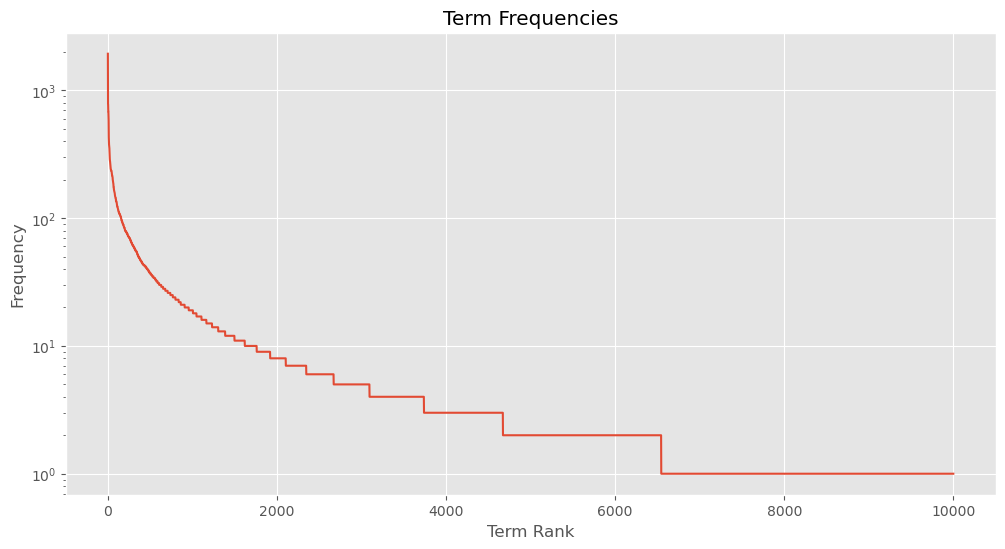

In [25]:
# Create a DataFrame of terms and their frequencies
term_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': X_train_bow.sum(axis=0).A1})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

# Display the top 20 terms
print(term_freq_df.head(20))

#print(term_freq_df.tail(10))

# Plot term frequencies
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(term_freq_df['frequency'].values)
#plt.plot(term_freq_df['frequency'].values[25000:26000])
plt.title('Term Frequencies')
plt.xlabel('Term Rank')
plt.ylabel('Frequency')
plt.yscale('log') 
plt.show()

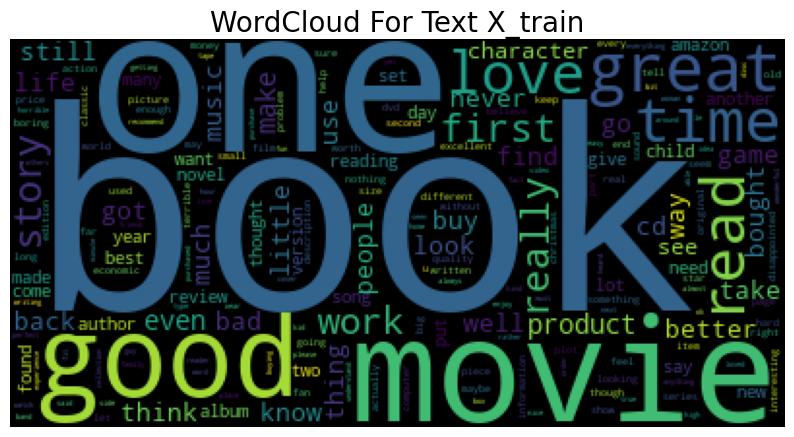

In [26]:
from wordcloud import WordCloud
plt.figure(figsize=(10,15))
plt.imshow(WordCloud().generate(" ".join(X_train.iloc[:1000])))
plt.axis("off")
plt.title("WordCloud For Text X_train", fontsize=20)
plt.show()

#### TF-IDF + ML Logistic Regression

In [27]:
# Filter terms with frequency >= 2
# Determine max_features based on the filtered terms
max_features = len(term_freq_df[term_freq_df['frequency'] >= 2])

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

voc_size = 20000
max_length = 100
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

print(list(word_index.items())[0:10])

[('book', 1), ('one', 2), ('like', 3), ('movie', 4), ('read', 5), ('great', 6), ('good', 7), ('time', 8), ('would', 9), ('get', 10)]


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train_tfidf, y_train)

# Predict on the validation data
y_val_pred = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")


# Displaying some predictions
print("\nPredictions for the first 5 validation samples:")
for i in range(5):  # Display first 5 val samples and their predictions
    print(f"Review: {X_val.iloc[i]}")
    print(f"True label: {y_val.iloc[i]}, Predicted label: {y_val_pred[i]}")

print("\nPredictions for test data")
# Predict on the validation data
y_test_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")


# Displaying some predictions
print("\nPredictions for the first 5 validation samples:")
for i in range(5):  # Display first 5 val samples and their predictions
    print(f"Review: {X_test.iloc[i]}")
    print(f"True label: {y_test.iloc[i]}, Predicted label: {y_test_pred[i]}")

Accuracy on validation set: 0.8028

Predictions for the first 5 validation samples:
Review: life father clarence day loved book preteen loved sequel life mother mr day paint accurate picture life early middle class family yes father rude bit obnoxious watching funny loved wife family blustered yelled loved enjoyed book thought great
True label: 2, Predicted label: 2
Review: poor instruction figure kinda cool wrap anything placed hot water searched internet found others problem instruction poor first need dip boiling water least temperature level would call hot second instruction describe happen image shrink around egg transfer needle say frustrating minute two wife intelligent great kitchen immediately thought well hot water much change property plastic let try boiling water nothing lose explicit instruction using star war version product
True label: 1, Predicted label: 1
Review: stupid honestly want hear lot swearing wont like let alone story line ridiculous recommend
True label: 1, P

#### **Tokenizer to Embedding Layers**

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer, Limit the vocabulary size to 5000
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the Tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the text data to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum length of sequences in X_train_seq
max_len = max(len(seq) for seq in X_train_seq)

# Pad the sequences to ensure they all have the same length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


# Print the first 10 sequences from training data as an example
print(f"first 10 sequences from training data: \n{X_train_seq[0]}")

# Print the first 10 padded sequences from training data as an example
print(f"\nfirst 10 padded sequences: \n{X_train_padded[:10]}")

# Print the first 10 elements from the word index
word_index = tokenizer.word_index
print("\nFirst 10 elements in word index:")
for word, index in list(word_index.items())[:10]:
    print(f"{word}: {index}")

first 10 sequences from training data: 
[6, 464, 1511, 846, 3113, 528, 1058, 3759, 714, 221, 379, 1511, 40, 1, 63, 131, 310, 613, 660, 217, 167, 715, 327, 174, 81, 36, 226, 6, 1633, 132, 1511, 686, 595, 51, 69, 273, 1511, 564, 6, 1, 1634, 68]

first 10 padded sequences: 
[[   6  464 1511 ...    0    0    0]
 [  89    5  287 ...    0    0    0]
 [ 966 3114 1775 ...    0    0    0]
 ...
 [  19 2694 1404 ...    0    0    0]
 [1936 1244 2369 ...    0    0    0]
 [   3    3   12 ...    0    0    0]]

First 10 elements in word index:
book: 1
one: 2
like: 3
movie: 4
read: 5
great: 6
good: 7
time: 8
would: 9
get: 10


<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > Model Building - Neutral Network Model<br><div>

In [30]:
import tensorflow as tf

# Convert y_train, y_val, y_test to binary (0/1)
y_train_bin = y_train.apply(lambda x: 1 if x == 2 else 0)
y_val_bin = y_val.apply(lambda x: 1 if x == 2 else 0)
y_test_bin = y_test.apply(lambda x: 1 if x == 2 else 0)

# Convert the padded sequences and labels to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_bin))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val_bin))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_bin))

# Batch and shuffle the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Model Definition
class SentimentModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, units):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.units = units
        self.embedding = tf.Variable(tf.random.normal([vocab_size, embedding_dim]), name='embedding')
        self.dense_1 = tf.Variable(tf.random.normal([embedding_dim, units]), name='dense_1')
        self.dense_2 = tf.Variable(tf.random.normal([units, 1]), name='dense_2')
        self.bias_1 = tf.Variable(tf.zeros([units]), name='bias_1')
        self.bias_2 = tf.Variable(tf.zeros([1]), name='bias_2')

    def __call__(self, x):
        x = tf.nn.embedding_lookup(self.embedding, x)
        x = tf.reduce_mean(x, axis=1)
        x = tf.nn.relu(tf.matmul(x, self.dense_1) + self.bias_1)
        x = tf.sigmoid(tf.matmul(x, self.dense_2) + self.bias_2)
        return x

    def predict(self, texts):
        texts = [text_cleaning(text) for text in texts]
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
        dataset = tf.data.Dataset.from_tensor_slices(padded_sequences)
        dataset = dataset.batch(batch_size)
        predictions = []
        for batch in dataset:
            pred_batch = self(batch)
            predictions.extend(pred_batch.numpy().flatten())
        return predictions

# Hyperparameters
embedding_dim = 50
units = 10
learning_rate = 0.001
epochs = 10

# Instantiate the model
model = SentimentModel(vocab_size=vocab_size + 1, embedding_dim=embedding_dim, units=units)

# Define the loss function and optimizer
loss_fn = tf.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.optimizers.Adam(learning_rate)

# Metrics
train_loss_metric = tf.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.metrics.BinaryAccuracy(name='train_accuracy')
val_loss_metric = tf.metrics.Mean(name='val_loss')
val_accuracy_metric = tf.metrics.BinaryAccuracy(name='val_accuracy')

# Training step function
@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update metrics
    train_loss_metric(loss)
    train_accuracy_metric(y, predictions)

# Validation step function
@tf.function
def val_step(model, x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
    
    # Update metrics
    val_loss_metric(loss)
    val_accuracy_metric(y, predictions)

# Training loop
for epoch in range(epochs):
    # Reset the metrics at the start of each epoch
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    val_loss_metric.reset_states()
    val_accuracy_metric.reset_states()
    
    # Training loop
    for x_batch, y_batch in train_dataset:
        train_step(model, x_batch, y_batch)
    
    # Validation loop
    for x_val_batch, y_val_batch in val_dataset:
        val_step(model, x_val_batch, y_val_batch)
    
    # Print metrics for each epoch
    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
    print(template.format(epoch+1,
                          train_loss_metric.result(),
                          train_accuracy_metric.result() * 100,
                          val_loss_metric.result(),
                          val_accuracy_metric.result() * 100))

# Evaluation on validation set
val_loss = tf.metrics.Mean()
val_accuracy = tf.metrics.BinaryAccuracy()
for x_val_batch, y_val_batch in val_dataset:
    val_predictions = model(x_val_batch)
    val_loss(loss_fn(y_val_batch, val_predictions))
    val_accuracy(y_val_batch, val_predictions)
print(f"Val Loss: {val_loss.result().numpy()}")
print(f"Val Accuracy: {val_accuracy.result().numpy() * 100}%")

# Evaluation on test set
test_loss = tf.metrics.Mean()
test_accuracy = tf.metrics.BinaryAccuracy()
for x_test_batch, y_test_batch in test_dataset:
    test_predictions = model(x_test_batch)
    test_loss(loss_fn(y_test_batch, test_predictions))
    test_accuracy(y_test_batch, test_predictions)

print(f"Test Loss: {test_loss.result().numpy()}")
print(f"Test Accuracy: {test_accuracy.result().numpy() * 100}%")

Epoch 1, Loss: 0.8870, Accuracy: 50.69%, Val Loss: 0.7656, Val Accuracy: 56.12%
Epoch 2, Loss: 0.7250, Accuracy: 57.03%, Val Loss: 0.6941, Val Accuracy: 58.10%
Epoch 3, Loss: 0.6583, Accuracy: 61.66%, Val Loss: 0.6635, Val Accuracy: 60.86%
Epoch 4, Loss: 0.6103, Accuracy: 66.55%, Val Loss: 0.6391, Val Accuracy: 64.22%
Epoch 5, Loss: 0.5696, Accuracy: 70.30%, Val Loss: 0.6117, Val Accuracy: 67.43%
Epoch 6, Loss: 0.5293, Accuracy: 74.46%, Val Loss: 0.5904, Val Accuracy: 70.49%
Epoch 7, Loss: 0.4930, Accuracy: 76.95%, Val Loss: 0.5698, Val Accuracy: 70.95%
Epoch 8, Loss: 0.4575, Accuracy: 79.93%, Val Loss: 0.5528, Val Accuracy: 72.02%
Epoch 9, Loss: 0.4279, Accuracy: 81.73%, Val Loss: 0.5351, Val Accuracy: 72.78%
Epoch 10, Loss: 0.3961, Accuracy: 84.25%, Val Loss: 0.5239, Val Accuracy: 74.46%
Val Loss: 0.5239066481590271
Val Accuracy: 74.46483373641968%
Test Loss: 0.48886623978614807
Test Accuracy: 73.33333492279053%


In [31]:
# Example usage of predict method
new_texts = [
    "Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors.",
    "If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated."
]
predictions = model.predict(new_texts)
for text, pred in zip(new_texts, predictions):
    print(f"Text: {text} -> Sentiment Probability: {pred:.4f}")

Text: Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors. -> Sentiment Probability: 0.5811
Text: If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated. -> Sentiment Probability: 0.5348


----------

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model.train_loss_history, label='Training Loss')
plt.plot(model.val_loss_history, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model.train_accuracy_history, label='Training Accuracy')
plt.plot(model.val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set
test_loss = []
test_accuracy = []

for x_test_batch, y_test_batch in test_dataset:
    predictions = model(x_test_batch)
    test_loss_batch = model.loss_fn(y_test_batch, predictions)
    test_accuracy_batch = tf.reduce_mean(tf.cast(tf.equal(tf.round(predictions), y_test_batch), tf.float32))
    test_loss.append(test_loss_batch.numpy())
    test_accuracy.append(test_accuracy_batch.numpy())

print(f"Test Loss: {tf.reduce_mean(test_loss):.4f}")
print(f"Test Accuracy: {tf.reduce_mean(test_accuracy) * 100:.2f}%")

# Generate classification report
test_predictions = model.predict(X_test)
test_predictions = [1 if pred >= 0.5 else 0 for pred in test_predictions]
print(classification_report(y_test_bin, test_predictions))

--------

<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">End</h1>
</center>